# Trotter Extrapolation

### James D. Watson, Jacob Watkins
### July 2024

# Table of contents
1. [Introduction](#introduction)
2. [Methods](#methods)
    1. [Linear Algebra Functions](#linalg)
    2. [Simulation Functions](#simulation)
    3. [Generating the Hamiltonian](#genHamiltonian)
    4. [Local Observables](#observable)
3. [Richardson Extrapolation](#richardson)
   1. [Testing Richardson Extrapolation](#test_richardson)
5. [Polynomial Interpolation](#polynomial_interpolation)
6. [Comparing Richardson and Polynomial Interpolation](#comparison)

# Introduction <a name="introduction"></a>

The aim of this code is to compare the efficiency of Richardson extrapolation vs Polynomial Interpolation for extrapolating expectation values in quantum simulation.


From Equation (1) of [this text](https://arxiv.org/abs/1711.10980), we want to simulate the 1D Heisenberg model.

$$
H = \sum_{i=1}^n \sigma_i \cdot \sigma_{i+1} + h_j \sigma_j^z
$$

with $h_j \in [-h,h]$ randomly and uniformly sampled. Suppose we wish to simulate $e^{-i H T}$ on a quantum computer using product formulas. A natural choice is to split according to even-odd staggering of the interaction term, and then do the $Z$ rotations in their own grouping. 

If $n$ is odd, one of the groupings will contain terms which don't commute. I don't think we should fret, probably just choose even $n$ for simplicity since we are only exploring our method. 

# Methods <a name="methods"></a>

## Useful Pauli and qubit manipulations 

In [1]:
# Imports

import numpy as np
import scipy.interpolate as interp
import scipy.linalg as sla
import numpy.linalg as nla
import matplotlib.pyplot as plt
import random as rand
from mpmath import *

In [4]:
# Computes Kronecker (tensor) product of a list of matrices
# Example:
# Input: [X,Y,Z,Y]
# Return: X \ox Y \ox Z \ox Y
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Pauli matrices
I = np.array([[1.,0],[0,1.]], dtype='complex')
X = np.array([[0,1.],[1.,0]], dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]], dtype='complex')
Z = np.array([[1.,0],[0,-1.]], dtype='complex')

# Converts string representation of paulis to list of matrices,
# Example:
# Input: "XYZY"
# Return: [X,Y,Z,Y]
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form,
# Example:
# Input: "XYZY"
# Return: X \ox Y \ox Z \ox Y
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
# of the form {k:'P', ..., } where k is the integer location and P is a pauli
# Example:
# Input: {0: 'X', 3:'Z', 5:'X'}, 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0, nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

# Returns the matrix of \sigma . \sigma between sites i and j
# Example:
# Input: 0,1,4
# Return: X\ox X \ox I \ox I + Y\ox Y \ox I \ox I + Z\ox Z \ox I \ox I
def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

# Qubit computational basis
zero = np.array([1.,0], dtype ='complex')
one = np.array([0,1.], dtype ='complex')

# Converts a bitstring to list of single-qubit kets
# Example: 
# Input: "0101"
# Output: list( (1,0), (0,1), (1,0), (0,1) )
def bitstring_to_list(bitstring):
    bitlist = list(bitstring)
    translate = {'0':zero, '1':one}
    for b in range(len(bitstring)):
        bitlist[b] = translate[bitlist[b]]
    return bitlist

# Converts a bitstring to full vector/array describing each qubit.
# Example: 
# Input: "0101"
# Output:  (1,0) \ox (0,1) \ox (1,0) \ox (0,1) 
def basis_ket(bitstring):
    return kron_list(bitstring_to_list(bitstring))


# Outputs a bit string with certain positions set to 1, and otherwise set to zero.
# Example: 
# Input: [0,1,2],3
# Output:  (0,0,0,0,0,0,0,0,1)
def sparse_bitstring(ones, nqubits):
    bitlist = ['0']*nqubits
    
    #Flip certain bits to one, as specified by list of qubit indices
    for qubit in ones:
        bitlist[qubit] = '1'
    
    # Convert list to bitstring
    bitstring = ''.join(bitlist)
    
    return basis_ket(bitstring)

## Linear Algebra Functions <a name="linalg"></a>

In [6]:
## We are working with large matrix powers. Here we use diagonalisation rather than the repeated square method to compute
## large exponents.
## Code taken from: https://saturncloud.io/blog/numpys-matrixpower-function-understanding-and-addressing-incorrect-results-for-large-exponents/

# Computer n^th power of square, diagonalisable matrix A:
def matrix_power_eigenvalue(A, n):
    #Adjust precision
    mp.dps = 20
    
    ## Use in-built hi-precision function:
    output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    
    return output

def matrix_power_eigenvalue_precise(A, n, precision=20):
    #Adjust precision
    mp.dps = precision
    
    
    ## Use in-built hi-precision function:
    #output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    output =  mp.powm(A, n)
   
    return output

# The old function
def matrix_power_eigenvalue_old(A, n):
   
    
    eigenvalues, eigenvectors = np.linalg.eig(A)
    D = np.diag(eigenvalues**n)
    print(D)
    output = fp.matrix( eigenvectors @ D @ np.linalg.inv(eigenvectors))
    
    
    return output

### Simulation Functions <a name="simulation"></a>

In [7]:
# Given: a positive integer, nqubits, and a list of n floats, hlist
# Generates the 1D Heisenberg chain Hamiltonian specified in the introduction.
def heisenbergH(nqubits, hlist):
    H = sigma_dot_sigma(0,1,nqubits) + hlist[0]*sparse_pauli({0:'Z'}, nqubits)
    for j in range(1, nqubits):
        H += sigma_dot_sigma(j, (j+1)%nqubits, nqubits) + hlist[j]*sparse_pauli({j:'Z'}, nqubits)
    return H

# Given a square matrix H and float T
# Returns the exact time evolution operator e^{-i H T} 
def Uexact(H, T):
    return sla.expm(-1.j*H*T)

## Returns the matrix with high precision exponentiation.
def Uexact_precise(H, T):
    
    #Adjust precision
    mp.dps = 20
    
    Uexact = mp.expm( -1.j*H*T , method='taylor')
    
    
    ## Use in-built hi-precision function:
    output =  np.array(Uexact.tolist(), dtype=complex)
    
    return output


# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short(Hterms, t, order = 1):
    m = len(Hterms) # number of terms
    result = sla.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ sla.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = sla.expm(-1.j*Hterms[k]*t/2) @ result @ sla.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result

# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short_precise(Hterms, t, order = 1, precision =20):
    
    #Adjust precision
    mp.dps = precision
    
    m = len(Hterms) # number of terms
    result = mp.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ mp.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = mp.expm(-1.j*Hterms[k]*t/2) @ result @ mp.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result
    
# Given: a list Hterms of square matrices of same dimension, float T, a (possibly noninteger) number of steps, and order =1,2
# Returns a Trotter evolution of given order and step number, for time T
def Utrot_long(Hterms, T, steps, order = 1):
    single_step = Utrot_short(Hterms, T/steps, order)
    
    integer_steps = int( np.floor(steps) )
    fractional_step = steps - integer_steps
    
    integer_step_evolve = matrix_power_eigenvalue(single_step, integer_steps)
    fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    return total_evolution

## Above, but high precision
def Utrot_long_precise(Hterms, T, steps, order = 1, precision =20):
    
    #Adjust precision
    mp.dps = precision
    
    
    single_step = Utrot_short_precise(Hterms, T/steps, order)
    
    step_evolve = matrix_power_eigenvalue(single_step, steps)
    #fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = step_evolve 
    
    return total_evolution

# Generate Breakdown of the Heisenberg Hamiltonian <a name="genHamiltonian"></a>

In [10]:
## Define the even, odd and potential terms for an arbitrary nunber of qubits and a given hlist.

def Even_Heisenberg_Terms(nqubits):
    Even = sigma_dot_sigma(0, 1, nqubits)
    for j in range(2,nqubits,2):
        Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
    return Even

def Odd_Heisenberg_Terms(nqubits):
    
    Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
    for j in range(3,nqubits,2):
        Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
        
    return Odd

def Potential_Heisenberg_Terms(nqubits, hlist):
    
    Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)
        
    return Potential





# Local Observable and Expectation Value Functions <a name="observable"></a>

In [11]:
## Define a Local Observable:

## Computes  Hermitian observable, specified by Pauli strings. Input is a list of dictionaries: nonidentities encoded as dictionary
## of the form {k:'P', ..., } where k is the integer location and P is a pauli. Pauli strings are then input as list.
# Example:
# Input: [{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X + I\ox X \ox  I \ox I \ox I \ox I
def observable(List_Pauli_strings, nqubits):

    local_observable = 0
    for k in range(len(List_Pauli_strings)):
        local_observable +=  sparse_pauli( List_Pauli_strings[k], nqubits )
    
    return local_observable

## Take expectation value of 'observable' with respect to to 'state'
# Example:
# Input: sparse_bitstring([0], 1), observable([{0: 'Z'}], 1) 
# Output: -1
def expectation_value(state, observable):
    
    normalisation =   np.vdot(state, state )  
    # Throw an exception if the state is not normalised.
    if (normalisation -1) > 0.00001:
        raise ValueError("State is not normalised")
    
    # Calculate the expectation of the state. Use vdot to get complex conjugate.
    expectation = np.vdot(state, observable.dot(state) )
    
    # Throw an exception if there is a significant imaginary part to the expectation value.
    if np.abs(expectation.imag) > 0.00001:
        raise ValueError("Expectation value should be entirely real")
        
    # Return only the real part of the expectation value (imaginary part should be zero).
    return np.real(expectation)

## Finds the expectation value with respect to the Trotterized time evolution. Define the function in terms of s = 1/steps.
# Example: 
# Input: [Even, Odd, Potential], sparse_bitstring([0,1], 2), 10, 0.01, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)

## High Precision Version of above.
def Trotterized_Expectation_precise(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long_precise(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)
    
## Computes the time-evolved expectation value from the *exact* evolution.  
# Example: 
# Input: heisenbergH(nqubits, hlist), sparse_bitstring([0,1], 2), 10, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Exact_Expectation(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)


## Precise version of the above.
def Exact_Expectation_Precise(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact_precise(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)




## Computes the magnetisation as a matrix.
# Example:
# Input: 5
# Output: (1/5)\sum_{i=1}^5 Z_i
def Magnetisation(nqubits):
    
    magnetisation_list = []
    
    # For each qubit we want to measure Z on that qubit and then add them together. Generate the Pauli string
    # representing this operator.
    for k in range(nqubits):
        magnetisation_list.append( { k : 'Z'} )
        
    # Calculate the matrix form of the local observable.
    magnetisation_matrix = (1/nqubits)*observable(magnetisation_list, nqubits)
    
    return magnetisation_matrix

## Error Performance and Analysis Functions

In [12]:
# Computes the 1-norm characterising the Hamiltonian & number of steps needed.
def Heisenberg_one_norm(nqubits, hlist):
    
    # First compute norm associated with the 2 qubit \sigma.\sigma terms.
    norm = (nqubits-1)*3
    
    # Compute part of norm associated with single-qubit terms.
    k = 0
    for k in range(nqubits):
        norm += np.abs( hlist[k] )
        
    return norm

## Calculates the minimum number of steps required analyticity to be maintained (using the one-norm bound).
def min_step_number(nqubits, hlist, time, order = 1 ):
    
    one_norm = Heisenberg_one_norm(nqubits, hlist)

    if order == 1:
        min_step_no = np.ceil(  (one_norm*time)**2)/2
    elif order == 2:
         min_step_no = np.ceil(  (one_norm*time)**(3/2))/6
    else:
        raise NameError('Orders >2 have not yet been implemented.')
    
    return int(min_step_no)

## Compares the difference between the exact and Trotterized expecation values.
def difference_function(Hterms, initial_state, time, s, observable, nqubits, order = 1):
    

    Hamiltonian = np.sum(Hterms,axis=0)
    
    # Calculate the difference between the exact evolution and the Trotter-zed evolution.
    exact_val = Exact_Expectation(Hamiltonian, initial_state, time, observable)
    trotter_val = Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1)
    diff = exact_val - trotter_val
    
    return diff



## Construct System Hamiltonian, Observable, and Initial State

In [13]:
## System parameters.
nqubits = 6
h = 1 # Maximum single qubit potential strength

# Define the Hamiltonian and the groupings of its terms.
hlist = (np.random.rand(nqubits)*2 -1)*h
Hterms = [Even_Heisenberg_Terms(nqubits), Odd_Heisenberg_Terms(nqubits), Potential_Heisenberg_Terms(nqubits, hlist)]
Htot = np.sum(Hterms, axis = 0)


# Choose local observable and initial state
local_obs_array = [{0: 'Z'},{nqubits-1: 'Z'}, {1: 'X'} ]
local_obs = observable(local_obs_array, nqubits)
#local_obs = Magnetisation( nqubits )
initial_state = sparse_bitstring([nqubits//2], nqubits)

# Richardson Extrapolation Functions <a name="richardson"></a>

In [143]:
## Calculates the order N Richarson extrapolation estimate.

def richardson_estimate(order, s_min, Hterms, initial_state, time, observable, trotter_order =2):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    
    for k in range(order):
        counter = k+1
        #Generate points to be sampled from.
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
        
        #Generate expectation values at those points.
        trotter_val = Trotterized_Expectation(Hterms, initial_state, time, sample_point, observable, order = trotter_order)
        #print(trotter_val)
        values_array.append( trotter_val )
        
        #Generate Coefficients for the Estimate:
        coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
        points_array.append( coefficient )
        
        estimate += coefficient*trotter_val
        estimate_array.append(estimate)

    
    return estimate

def richardson_estimate_precise(order, s_min, Hterms, initial_state, time, observable, trotter_order =2):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    
    #Adjust precision
    mp.dps = 20
    
    for k in range(order):
        counter = k+1
        #Generate points to be sampled from.
        sample_point = s_min*( mp.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
        
        #Generate expectation values at those points.
        trotter_val = Trotterized_Expectation_precise(Hterms, initial_state, time, sample_point, observable, order = trotter_order)
        print(trotter_val)
        values_array.append( trotter_val )
        
        #Generate Coefficients for the Estimate:
        coefficient = (((-1)**(counter+1))/order)*(1 / mp.tan(np.pi*(2*counter-1)/(4*order) ))
        points_array.append( coefficient )
        
        estimate += coefficient*trotter_val
        estimate_array.append(estimate)

    
    return estimate


## Use this the following function to simulate the effects of random noise on the estimate.

def richardson_estimate_error(order, s_min, Hterms, initial_state, time, observable, error_param, trotter_order =2):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    
    for k in range(order):
        counter = k+1
        #Generate points to be sampled from.
        #points_array.append( s_min*(np.sin(np.pi*(2*k-1)/4*order))**2  )
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
        
        #Generate expectation values at those points.
        trotter_val = Trotterized_Expectation(Hterms, initial_state, time, sample_point, observable, trotter_order)+ np.random.uniform(-error_param, error_param)
        values_array.append( trotter_val )
        #print("Measured Values", values_array)
        
        #Generate Coefficients for the Estimate:
        coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
        points_array.append( coefficient )
        
        estimate += coefficient*trotter_val
        estimate_array.append(estimate)


    
    return estimate



## Testing Richardson Extrapolation <a name="test_richardson"></a>

In [17]:
## Test case.

# Set initial parameters.
order         = 1
time          = 1
min_step_no   = min_step_number(nqubits, hlist, time)
s_min         = 1/min_step_no
failure_prob  = 0.01
trot_order    = 2 

approximation = richardson_estimate(order, s_min, Hterms, initial_state, time, local_obs, trotter_order =2)

exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)

error = exact_val - approximation

relative_error = error/exact_val

print("Error:", error,"Exact Value:","Relative Error:", relative_error , exact_val,"Richardson Approximation:", approximation)

1.2689250173432802
Error: -9.204176060650937e-06 Exact Value: 1.2689158131672198 Richardson Approximation: 1.2689250173432804


# Polynomial Interpolation <a name="polynomial_interpolation"></a>

 We can use `scipy.interpolate` for the interpolating polynomials.

In [18]:
## Creates a list of n Chebyshev nodes in the interval [-halfwidth + center , halfwidth +center ]. 
# Input: a positive integer n and interval of given halfwidth and center,
# Returns: a list of the n Chebyshev nodes (zeros of the nth degree chebyshev polynomial on that interval)
def cheb_nodes(n, halfwidth = 1, center = 0):
    nodes = np.zeros(n)
    for j in range(n):
        nodes[n-j-1] = center + halfwidth * np.cos((2*j+1)*np.pi/(2*n))
    return nodes

## Computing the Interpolating Function

In [19]:
## Outputs the num_nodes degree Chebyshev approximation to the "order"-degree Trotter evolution.

def degree_N_Chebyshev(num_nodes, interval_width, Hterms, initial_state, time, local_obs, order = 2):
    
    # Generate array of nodes and initialise array to contain output values.
    slist = cheb_nodes(num_nodes, interval_width)
    ylist = np.zeros(num_nodes)
    
    # Generate the values we wish to interpolate.
    for k in range(0, num_nodes):
        # Compute the Trotter estimate at each Chebyshev node.
        ylist[k] = Trotterized_Expectation(Hterms, initial_state, time, slist[k], local_obs, order = trot_order)
    
    # Generate the interpolating function.
    interpolant = interp.BarycentricInterpolator(slist,ylist)
    
    return interpolant


## Outputs the extrapolated value at s=0.

def extrapolated_value(num_nodes, interval_width, Hterms, initial_state, time, local_obs, order = 2):

    Chebyshev_approx = degree_N_Chebyshev(num_nodes, interval_width, Hterms, initial_state, time, local_obs, order = 2)
    
    return Chebyshev_approx(0)
    
    
def degree_N_Chebyshev_error(num_nodes, interval_width, Hterms, initial_state, time, local_obs, error_param, order = 2):
    
    # Generate array of nodes and initialise array to contain output values.
    slist = cheb_nodes(num_nodes, interval_width)
    ylist = np.zeros(num_nodes)
    
    # Generate the values we wish to interpolate.
    for k in range(0, num_nodes):
        # Compute the Trotter estimate at each Chebyshev node.
        ylist[k] = Trotterized_Expectation(Hterms, initial_state, time, slist[k], local_obs, order = trot_order)+ np.random.uniform(-error_param, error_param)
    
    # Generate the interpolating function.
    interpolant = interp.BarycentricInterpolator(slist,ylist)
    
    return interpolant    

## Error Scaling with Degree of Richardson Approximation

1.2689250173432802
1.2689185088806734
1.268931526420686
1.2689170462216801
1.2689250173432802
1.2689329893870998
1.2689165137503406
1.2689214949124215
1.2689285399541435
1.268933521985744
1.2689162636227203
1.2689196071154312
1.2689250173432802
1.2689304279958404
1.2689337721756648
1.2689161267715883
1.2689185088806734
1.2689226350092113
1.268927399759596
1.268931526420686
1.268933909061988
1.268916043919502
1.2689178211241245
1.2689210236498898
1.2689250173432802
1.2689290112679208
1.2689322143142614
1.2689339919352072
1.2689159900108173
1.2689173642641918
1.2689199036249916
1.2689232216012327
1.2689268131321585
1.2689301314406785
1.268932671272093
1.2689340458579046
1.2689159529907499
1.2689170462216801
1.268919100871551
1.2689218691911506
1.2689250173432802
1.2689281656390268
1.2689309343227202
1.2689329893870998
1.2689340828888707


Text(0.5, 1.0, 'Error at Different Circuit Depths')

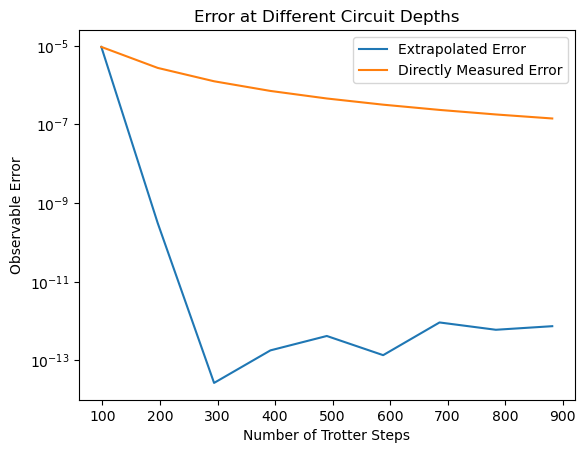

In [20]:
## Here we see how the error changes with the number of interpolating nodes/the degree of the approximating polynomial.

trot_order      = 2
time            = 1
s_min           = 1/min_step_no
max_node_number = 10

points_array = []
estimated_value_list = []
degree_array = []
error_array = []
best_data_val_array = []
best_val_error_array = []


# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)

        
# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1, max_node_number):
    
    order = k
    approximation = richardson_estimate(order, s_min, Hterms, initial_state, time, local_obs, trotter_order =2)
    
    # Calculate the estimated value from the s=0 value of the interpolation
    estimated_value_list.append( approximation )
    degree_array.append( k )
    # Calculate the error relative to the exact value.
    error_array.append( np.abs( exact_val - estimated_value_list[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    # This is essentially calculating the best measurement error.
    
    # Generate a list of points to be sampled from.
    for m in range(1, max_node_number):
        counter = m
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
    
    # Now find the minimum on that list, and check the error associated with measuring the observable there.
    min_value_points_array = min(np.abs(points_array) )
    best_data_val_array.append( Trotterized_Expectation(Hterms, initial_state, time, min_value_points_array, local_obs, order = trot_order)  )
    best_val_error_array.append( np.abs( exact_val - best_data_val_array[k-1] )  )

    
    
# Convert array into the circuit depth in terms of elementary exponentials.

circuit_depth_array = min_step_number(nqubits, hlist, time)*(1/2)*np.array( degree_array )


# Plot graphs.

plt.semilogy(circuit_depth_array, error_array,  label="Extrapolated Error")
plt.semilogy(circuit_depth_array, best_val_error_array, label="Directly Measured Error"  )
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

# Comparing Richardson and Polynomial Extrapolation Methods <a name="comparison"></a>

Here we compare the Richardson and Polynomial Extrapolation Methods

In [24]:
# Set initial parameters.
trot_order    = 2 
order         = 2
time          = 1
min_step_no   = min_step_number(nqubits, hlist, time, order = 2 )
s_min         = 1/min_step_no
failure_prob  = 0.01


#### Initialise a Hamiltonian

In [145]:
## Initialise a set of Hamiltonian 

# System parameters.
nqubits = 5
h = 3 # Maximum single qubit potential strength

# Define the Hamiltonian and the groupings of its terms.
hlist = (np.random.rand(nqubits)*2 -1)*h
Hterms = [Even_Heisenberg_Terms(nqubits), Odd_Heisenberg_Terms(nqubits), Potential_Heisenberg_Terms(nqubits, hlist)]
Htot = np.sum(Hterms, axis = 0)


# Choose local observable and initial state
initial_state = sparse_bitstring([nqubits//2], nqubits)
#local_obs = Htot 

local_obs_array1= [{0: 'Z'},{nqubits-1: 'Z'}, {1: 'X'} ]
local_obs_array2= [{0: 'X'}, {1:'Y'}, {nqubits-1: 'I'}]
local_obs = observable(local_obs_array1, nqubits) + observable(local_obs_array2, nqubits)
local_obs_array= [{0: 'X'}, {1:'Y'}, {nqubits-1: 'I'}]
#local_obs = observable(local_obs_array, nqubits)
#local_obs = Magnetisation( nqubits )


#### Error Scaling with Degree of Richardson Approximation

#### Plot the Richardson Results

In [146]:
points_array_Richardson = []
depth_array_Richardson  = []
estimated_value_list_Richardson = []
degree_array_Richardson = []
error_array_Richardson  = []
best_data_val_array_Richardson  = []
best_val_error_array_Richardson = []


# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)

# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1, max_node_number):
    
    order = k
    approximation = richardson_estimate(order, s_min, Hterms, initial_state, time, local_obs, trotter_order =2)
    # Calculate the estimated value from the s=0 value of the interpolation
    estimated_value_list_Richardson.append( approximation )
    degree_array_Richardson.append( k )
    # Calculate the error relative to the exact value.
    error_array_Richardson.append( np.abs( exact_val - estimated_value_list_Richardson[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    # This is essentially calculating the best measurement error.
    
    # Generate a list of points to be sampled from.
    points_array_Richardson.append([])
    depth_array_Richardson.append([])
    for m in range(1, order+1): #max_node_number):
        counter = m
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        #print("Sample point", k, m, ":", sample_point)
        points_array_Richardson[k-1].append( sample_point  )
        depth_array_Richardson[k-1].append( 1/sample_point )
    
    # Now find the minimum on that list, and check the error associated with measuring the observable there.
    min_value_points_array = min(np.abs(points_array_Richardson[k-1]) )
    best_data_val_array_Richardson.append( Trotterized_Expectation(Hterms, initial_state, time, min_value_points_array, local_obs, order = trot_order)  )
    best_val_error_array_Richardson.append( np.abs( exact_val - best_data_val_array_Richardson[k-1] )  )

# Convert array into the circuit depth in terms of elementary exponentials.

circuit_depth_array_Richardson = min_step_no*(1/2)*np.array( degree_array )

# Extract the maximum circuit depth for each Richardson run.
maximum_depths_Richardson = [max(x) for x in depth_array_Richardson]


Text(0.5, 1.0, 'Error at Different Circuit Depths')

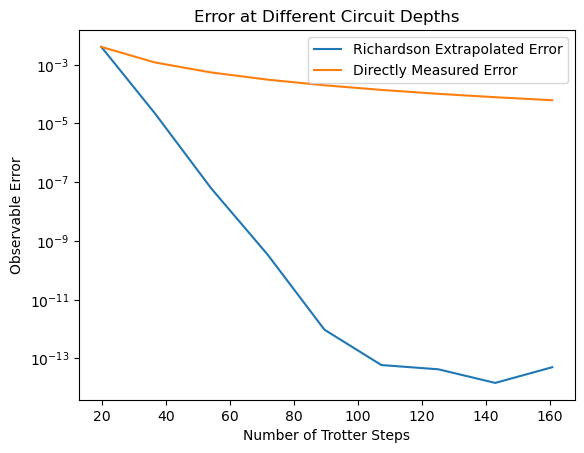

In [147]:
# Plot graphs.
plt.semilogy(maximum_depths_Richardson, error_array_Richardson,  label="Richardson Extrapolated Error")
plt.semilogy(maximum_depths_Richardson, best_val_error_array_Richardson, label="Directly Measured Error"  )
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

#### Error Scaling with Degree of Polynomial Interpolation

In [148]:
Chebyshev_approx_array    = []
estimated_value_list_poly = []
degree_array_poly = []
error_array_poly  = []
best_data_val_array_poly  = []
best_val_error_array_poly = []
circuit_depth_array_poly  = []
list_max_poly = []


# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1,int(max_node_number/2)):
    # Cacluate the interpolating function for the degree 2*k Chebyshev interpolant.
    Chebyshev_approx_array.append( degree_N_Chebyshev(2*k, s_min, Hterms, initial_state, time, local_obs, order = trot_order) )
    # Calculate the estimated value from the s=0 value of the interpolation
    estimated_value_list_poly.append( Chebyshev_approx_array[k-1](0) )
    degree_array_poly.append( 2*k)
    # Calculate the error relative to the exact value.
    error_array_poly.append( np.abs( exact_val - estimated_value_list_poly[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    s_list = cheb_nodes(2*k, s_min)
    print("s_list", k, ":", s_list)
    list_max_poly.append( 1/min(abs(s_list)) )
    best_data_val_array_poly.append( Trotterized_Expectation(Hterms, initial_state, time, s_list[k], local_obs, order = trot_order)  )
    best_val_error_array_poly.append( np.abs( exact_val - best_data_val_array_poly[k-1] )  )


# Convert array into the circuit depth in terms of elementary exponentials.
circuit_depth_array_poly = min_step_no *(1/4)*np.array( degree_array_poly )
    

s_list 1 : [-0.05050763  0.05050763]
s_list 2 : [-0.0659914  -0.02733453  0.02733453  0.0659914 ]
s_list 3 : [-0.0689947  -0.05050763 -0.01848707  0.01848707  0.05050763  0.0689947 ]
s_list 4 : [-0.07005609 -0.05939069 -0.03968359 -0.01393502  0.01393502  0.03968359
  0.05939069  0.07005609]


#### Plot Polynomial Interpolation Results

Text(0.5, 1.0, 'Error at Different Circuit Depths')

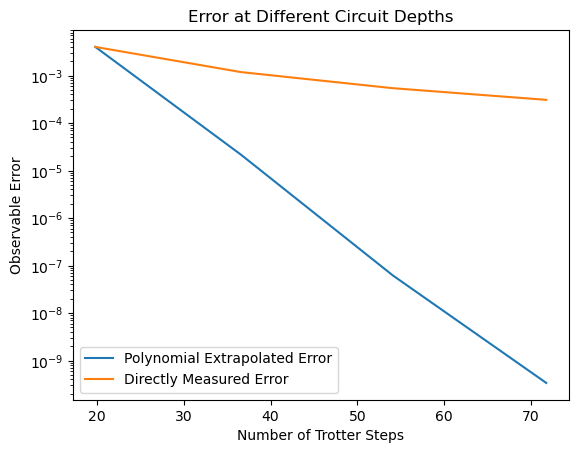

In [149]:
#plt.semilogy(circuit_depth_array_poly, error_array_poly,  label="Polynomial Extrapolated Error")
#plt.semilogy(circuit_depth_array_poly,  best_val_error_array_poly, label="Directly Measured Error"  )
plt.semilogy(list_max_poly, error_array_poly,  label="Polynomial Extrapolated Error")
plt.semilogy(list_max_poly,  best_val_error_array_poly, label="Directly Measured Error"  )
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

#### Plot Richardson Extrapolation and Polynomial Interpolation Simultaneously

Text(0.5, 1.0, 'Error at Different Circuit Depths')

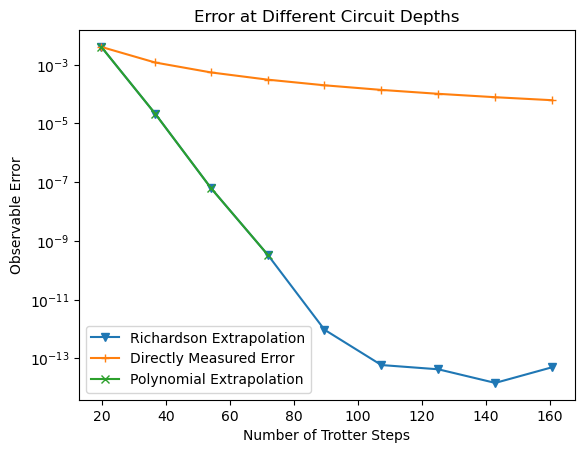

In [150]:

plt.semilogy(maximum_depths_Richardson, error_array_Richardson,  label="Richardson Extrapolation", marker = 'v')
plt.semilogy(maximum_depths_Richardson, best_val_error_array_Richardson, label="Directly Measured Error", marker = '+')
plt.semilogy(list_max_poly, error_array_poly,  label="Polynomial Extrapolation", marker = 'x')
#plt.semilogy(circuit_depth_array_poly,  best_val_error_array_poly, label="Directly Measured Error"  )
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

# Comparison with Different Sampling Points

##### The previous routine incidentally used the same sampling points to give the same answers. Here we change this.

In [225]:
## Define the relevant functions for the generic case.


def generate_adjusted_nodes(s_min, order, type = 'regular' ):

    points_array_Richardson = []

    # Generate regular Chebyshev nodes:
    if type == 'regular':
        for j in range(1, order+1): 
            counter = j
            sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
            points_array_Richardson.append( sample_point  )

    # Generate adjusted Chebyshev nodes:
    elif type == 'adjusted':
        for j in range(1, order+1): 
            counter = j
            sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*2*order)) )
            points_array_Richardson.append( sample_point  )

    # Generate rounded Chebyshev nodes:
    elif type == 'rounded':
        for j in range(1, order+1): 
            counter = j
            K = np.log2(order)
            sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*2*order)) )
            points_array_Richardson.append( np.floor(sample_point/K)  )

    return points_array_Richardson

# Given a list of sample points, returns the Vandermode matrix.
def Vandermode_generator(s_list, order):

    Vandermode_matrix = []
    
    # Now fill in the samples.
    for j in range(order):
        Vandermode_matrix.append([])
        [Vandermode_matrix[j].append(x**(2*j)) for x in s_list ]

    Vandermode_matrix = np.array( Vandermode_matrix )
    
    return Vandermode_matrix


# Find Richardson extrapolation coefficients.
def Richardson_coefficient_finder(s_list, order):
    
    # Generate the Vandermode matrix.
    V = Vandermode_generator(s_list, order)

    # Now solve for vector of a's.
    single_element    = [0]*order
    single_element[0] = 1
    single_element = np.array(single_element)

    a_array = np.linalg.inv(V) @ single_element

    return a_array



# Performs the Richardson extrapolation procedure with generic sampling points by inverting the Vandermode matrix.
def richardson_estimate_generic(order, s_list, Hterms, initial_state, time, observable, trotter_order =2):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0

    # Generate the expectation values of the Trotterization at the sample points.

    for sample_point in s_list:
        trotter_val = Trotterized_Expectation(Hterms, initial_state, time, sample_point, observable, order = trotter_order)
        values_array.append( trotter_val )

    #Generate Coefficients for the Estimate:
    a_array = Richardson_coefficient_finder(s_list, order)
    
    #Generate the estimate:
    for k in range(len(a_array)):
        estimate += a_array[k]*values_array[k]
        #coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
        #points_array.append( coefficient )
        
        #estimate += coefficient*trotter_val
        #estimate_array.append(estimate)

    
    return estimate

In [151]:
s_list = cheb_nodes(2*k, s_min)
print(s_list)

[-0.07005609 -0.05939069 -0.03968359 -0.01393502  0.01393502  0.03968359
  0.05939069  0.07005609]


In [161]:
points_array_Richardson = []
depth_array_Richardson = []
order = 4

for m in range(1, order+1): #max_node_number):
    counter = m
    sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
    #print("Sample point", k, m, ":", sample_point)
    points_array_Richardson.append( sample_point  )
    depth_array_Richardson.append( 1/sample_point )

print(points_array_Richardson)
print("Depths:",depth_array_Richardson)

[0.013935023001152017, 0.03968358807282873, 0.05939068659303894, 0.0700560914573736]
Depths: [71.76163253676218, 25.199334247819642, 16.837656834181267, 14.274276214916458]


In [163]:
## New k' Richardson sampling points
points_array_Richardson = []
depth_array_Richardson = []
order = 4

for j in range(1, order+1): #max_node_number):
    counter = j
    sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*2*order)) )
    #print("Sample point", k, m, ":", sample_point)
    points_array_Richardson.append( sample_point  )
    depth_array_Richardson.append( 1/sample_point )

print(points_array_Richardson)
print("Depths", depth_array_Richardson)

[0.013935023001152017, 0.03968358807282873, 0.05939068659303894, 0.0700560914573736]
Depths [71.76163253676218, 25.199334247819642, 16.837656834181267, 14.274276214916458]


In [222]:
s_list = generate_adjusted_nodes(s_min, order=4, type = 'regular' )
points_array2 = Richardson_coefficient_finder(s_list, order)
print(points_array2)

[ 1.25683487 -0.37415144  0.16704466 -0.04972809]


# Tests 

In [224]:
## Test the point generation functions are consistent.

print( generate_adjusted_nodes(s_min, order=4, type = 'regular' ) ) 
print( cheb_nodes(2*order, s_min) )


## Check the coefficient generation is consistent.
points_array = []
for k in range(order):
    counter = k+1
    #Generate Coefficients for the Estimate:
    coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
    points_array.append( coefficient )

print(points_array)

s_list = generate_adjusted_nodes(s_min, order=4, type = 'regular' )
points_array2 = Richardson_coefficient_finder(s_list, order)
print(points_array2)

[0.013935023001152017, 0.03968358807282873, 0.05939068659303894, 0.0700560914573736]
[-0.07005609 -0.05939069 -0.03968359 -0.01393502  0.01393502  0.03968359
  0.05939069  0.07005609]
[1.256834873031462, -0.3741514406663723, 0.16704465947982475, -0.04972809184491452]
[ 1.25683487 -0.37415144  0.16704466 -0.04972809]


In [ ]:
## Test the generic Richardson extrapolation versus the specific case.

richardson_estimate(order, s_min, Hterms, initial_state, time, observable, trotter_order =2)